In [55]:
import numpy as np
import pandas as pd
import pdb
import setuptools

%matplotlib inline 
%load_ext cython 

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


[ 1.31642291  0.96988474  0.02628693 -1.17469312 -2.60498003 -3.71265689
  0.13847987  3.00409504 -0.10888454 -0.76045385  1.77621455 -2.58722542
  1.75415228  3.31642215  1.33149651 -1.91378051  0.10570807 -0.43289448
 -0.88201089  0.15426474  1.029299    0.74173705  3.37144308  2.50855023
  2.47495168  0.36044242  2.90080721  1.68594897 -1.34583566  1.1784758
  1.28283798  3.1740914   1.84381318  0.60116135  3.75006922 -1.52354547
  0.61739438  2.93934143  3.2937978   4.11649499  2.15749518  0.2619805
  1.3872382   3.38171304  1.07654268  0.23773026  2.23720513  0.24113263
 -0.56943693 -3.8854649   1.91450066 -1.90842175 -0.03806251 -0.50976094
 -0.58281653 -0.16101965  0.37139012  4.25417983  0.55376197 -1.13451243
  0.9555704   1.90002667  2.15544493  3.89700112  1.38027716  2.08358471
 -2.89807402  1.14285094  2.67451231  0.77406649  1.87389941 -0.83457085
 -4.01386921  0.98445653  0.96744563  2.67166658  3.6730758   0.69316202
  1.37769579  6.06040761 -2.83941138 -1.21999551  4.2

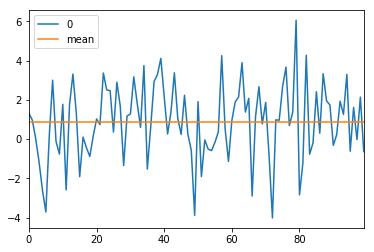

In [56]:
arr = np.random.normal(loc=1,scale=2,size=(100,1))
df = pd.DataFrame(arr)
df['mean'] = df.iloc[:,0].mean()
df.plot()
vec = df.iloc[:,0].values
print vec

In [57]:

def hint_value_count(vec,val):
    '''
    INPUT:
        vec : iterable containor
        val : value to bench line 
    OUPUT:
        the count bench line been hint
    WARNING:
    static series input will return 0, like:
    [1,1,1,1,1] , 1 -> return 0
    [1] , 1         -> return 0  
    '''
    count = 0
    for i,v in enumerate(vec):
        if len(vec) == 1:
            return 0
        if i > 0:
            xor = ((prev - val) > 0) ^ ((v - val) > 0)
            if xor:
                count += 1
            prev = v
        else:
            prev = v
    return count

def hint_value_mean(vec):
    return hint_value_count(vec,np.nanmean(vec))
    

In [58]:
def hint_value_mean_tj_py(vec):
    res = 0
    m = vec.mean()
#     print m
    if vec[0] - m < 0:
        flag_small = True
    else:
        flag_small = False
    for v in vec[1:]:
        if v - m < 0:#现在在均线下方
            if flag_small :#之前都是在均线下方
                continue
            else:
#                 print v,flag_small
                res += 1
                flag_small = True
        else:#现在在均线上方
            if not flag_small:#之前都是在均线上方
                continue
            else:
#                 print v,flag_small
                res += 1
                flag_small = False
    return res

In [59]:
%%cython 
import numpy as np
cimport numpy as np
import pandas as pd

cpdef hint_value_mean_tj_cy_bench(vec):
    res = 0
    m = vec.mean()
#     print m
    if vec[0] - m < 0:
        flag_small = True
    else:
        flag_small = False
    for v in vec[1:]:
        if v - m < 0:#现在在均线下方
            if flag_small :#之前都是在均线下方
                continue
            else:
#                 print v,flag_small
                res += 1
                flag_small = True
        else:#现在在均线上方
            if not flag_small:#之前都是在均线上方
                continue
            else:
#                 print v,flag_small
                res += 1
                flag_small = False
    return res

# @cython.boundscheck(False) # turn off bounds-checking for entire function
# @cython.wraparound(False)
cdef int hint_value_mean_tj_cy(np.ndarray[np.float32_t,ndim=1] vec):
    cdef int res = 0
    cdef float m = vec.mean()
    cdef float v
#     cdef np.bool_t flag_small
#     print m
    if vec[0] - m < 0:
        flag_small = True
    else:
        flag_small = False
    for v in vec[1:]:
        if v - m < 0:#现在在均线下方
            if flag_small :#之前都是在均线下方
                continue
            else:
#                 print v,flag_small
                res += 1
                flag_small = True
        else:#现在在均线上方
            if not flag_small:#之前都是在均线上方
                continue
            else:
#                 print v,flag_small
                res += 1
                flag_small = False
    return res 



print hint_value_mean_tj_cy(np.array([-0.47669166 , 0.44250423 , 1.0235505],dtype=np.float32))

## 正式版本

In [60]:
%%cython 
import numpy as np
cimport numpy as np

ctypedef fused Dtype_t:
    np.float32_t
    np.float64_t
    np.int32_t
    
ctypedef fused Dtype_s:
    float
    double
    int
    

cdef int hint_value_count_core(np.ndarray[Dtype_t] vec,Dtype_s val):
    
    cdef int res = 0
    cdef double v 
    
#     cdef bool flag_small
#     print m
    if vec[0] - val < 0:
        flag_small = True
    else:
        flag_small = False
    for v in vec[1:]:
        if v - val < 0:#现在在均线下方
            if flag_small :#之前都是在均线下方
                continue
            else:
#                 print v,flag_small
                res += 1
                flag_small = True
        else:#现在在均线上方
            if not flag_small:#之前都是在均线上方
                continue
            else:
#                 print v,flag_small
                res += 1
                flag_small = False
    return res

def hint_value_count(vec,val):
    if vec.dtype == np.float32:
        return hint_value_count_core [np.float32_t,float] (vec,val)
    elif vec.dtype == np.float64:
        return hint_value_count_core [np.float64_t,double] (vec,val)
    elif vec.dtype == np.int32:
        return hint_value_count_core [np.int32_t,int] (vec,val)
    else:
        raise NotImplementedError 

def hint_value_count_mean(vec):
    return hint_value_count(vec,np.nanmean(vec))

print hint_value_count_mean (np.array([-0.47669166 , 0.44250423 , 1.0235505],dtype=np.float32))
print hint_value_count_mean (np.array([-0.47669166 , 0.44250423 , 1.0235505],dtype=np.float64))
print hint_value_count_mean (np.array([1 , 2 , 3],dtype=np.int32))

In [39]:
vec = np.array([-0.47669166 , 0.44250423 , 1.0235505 , -0.17435179 , 0.20374418 , 1.10609406
                          ,1.9272145 , -0.29221452 , 1.54302712 , 2.73083613 , 2.25519686 , -1.00868019
                         ,-1.04170201 ,-2.25622641 , 1.34507115 , 2.3369955  , 3.04845752 , 2.09807164
                         , 3.07627961 , 0.12589722 , 1.39549719 , 2.04904437 , 3.31160252 , 2.37681115
                         ,-0.43697606],dtype=np.float32)

In [55]:
%timeit hint_value_mean_tj_py(vec)
%timeit hint_value_mean_tj_cy(vec)
%timeit hint_value_mean_tj_cy_bench(vec)
%timeit hint_value_mean(vec)

10000 loops, best of 3: 78.3 µs per loop
10000 loops, best of 3: 21.6 µs per loop
10000 loops, best of 3: 74.4 µs per loop
1000 loops, best of 3: 306 µs per loop


In [8]:
hint_value_mean_tj_cy(vec)

NameError: name 'hint_value_mean_tj_cy' is not defined

In [42]:
%prun 
hint_value_mean_tj(vec)


39

In [9]:
hint_value_mean = hint_value_mean_tj 

In [7]:
print hint_value_count(vec,np.nanmean(vec))
print hint_value_mean(vec)

8
8


In [17]:
%tb
import unittest
import time
import numpy as np

class TestHintValueMean(unittest.TestCase):
    def setUp(self):
        pass

    def tearDown(self):
        pass

    def test_core_logic1(self):
        vec = np.array([-0.99065953, 3.7386871 ,  2.50618797 , 2.11198829 , 1.21186976 , 2.09338828
                          ,1.58153956, -0.10506563 , 1.53332777 , 2.94602832 , 3.9844553  , 2.90796741
                          ,0.5843126 ,  2.09426637 , 2.57197391 , 5.29092433 , 1.30601905 , 0.23224612
                          ,2.63888202 ,-2.9009299  ,-0.76876908  ,2.23563598 , 3.70116308 ,-2.22792873
                          ,0.94923266])
        self.assertEqual(12,hint_value_mean(vec) ) 
        
    def test_core_logic2(self):
        vec = np.array([-0.47669166 , 0.44250423 , 1.0235505 , -0.17435179 , 0.20374418 , 1.10609406
                          ,1.9272145 , -0.29221452 , 1.54302712 , 2.73083613 , 2.25519686 , -1.00868019
                         ,-1.04170201 ,-2.25622641 , 1.34507115 , 2.3369955  , 3.04845752 , 2.09807164
                         , 3.07627961 , 0.12589722 , 1.39549719 , 2.04904437 , 3.31160252 , 2.37681115
                         ,-0.43697606])
        self.assertEqual(8,hint_value_mean(vec) ) 
        
    def test_core_logic3(self):
        vec = np.array([1.,2.,3.,4.,5.,6.])
        self.assertEqual(1,hint_value_mean(vec) ) 
        
    def test_core_logic4(self):
        vec = np.array([1.,1.,1.,1.,1.,1.])
        self.assertEqual(0,hint_value_mean(vec) ) 
        
    def test_core_logic5(self):
        vec = np.array([1.])
        self.assertEqual(0,hint_value_mean(vec) )
        
    def test_input_type_pandas_series(self):
        vec = pd.Series(np.array([1.,2.,3.,4.,5.,6.]))
        self.assertEqual(1,hint_value_mean(vec) )     
        
    def test_input_type_list(self):
        vec = [1.,2.,3.,4.,5.,6.]
        self.assertEqual(1,hint_value_mean(vec) )
        
    def test_input_type_numpy_array_int(self):
        vec = [1,2,3,4,5,6]
        self.assertEqual(1,hint_value_mean(vec) )  
        
    def test_performance(self):
        vec = np.random.normal(size=(100000,1))
        
        start = time.time()
        hint_value_mean(vec)
        end = time.time()
        self.assertLessEqual(end - start ,0.7) 
        
    
    
obj = unittest.main(argv=['ignored', '-v'], exit=False)

NameError: name 'np' is not defined

test_core_logic1 (__main__.TestHintValueMean) ... ok
test_core_logic2 (__main__.TestHintValueMean) ... ok
test_core_logic3 (__main__.TestHintValueMean) ... ok
test_core_logic4 (__main__.TestHintValueMean) ... ok
test_core_logic5 (__main__.TestHintValueMean) ... ok
test_input_type_list (__main__.TestHintValueMean) ... ERROR
test_input_type_numpy_array_int (__main__.TestHintValueMean) ... ERROR
test_input_type_pandas_series (__main__.TestHintValueMean) ... ok
test_performance (__main__.TestHintValueMean) ... ok

ERROR: test_input_type_list (__main__.TestHintValueMean)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-17-05fa68a64cab>", line 47, in test_input_type_list
    self.assertEqual(1,hint_value_mean(vec) )
  File "<ipython-input-16-0611fb20bfc8>", line 3, in hint_value_mean
    m = vec.mean()
AttributeError: 'list' object has no attribute 'mean'

ERROR: test_input_type_numpy_array_int (__main__.TestHint